<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%9D%D0%A1_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание Light 

Используя шаблон ноутбука, используйте базу квартир чтобы осуществить следующее следующее:

Загрузить xTrain на числовых данных.

Загрузить xTrainС из Примечаний (тексты).

Создать словарь.

Превратить xTrainC в формат bag of words (2000 самых популярных слов).

Сделать нормирование данных.

Написать нейронную сеть.

Как посмотрел задание, оно полностью совпадает с ноутбуком. Консультировался с куратором. Он разрешил копировать Парсинг данных. Только не пойму, чем задание отличается от Ультра Лайт. 

# Загрузка библиотек и БД квартир

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import utils
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback 
from tensorflow.keras.utils import plot_model
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/БАЗЫ/moscow Base.csv', sep=';')
df = df.iloc[::2,:] # нда, а я по другому избавлялся раньше.. теперь узнал другой способ
df = df.reset_index(drop=True) # внесу ясность в индексы
data = df.values 


In [ ]:
df[-5:]

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
126263,Ст,Некрасовка м.,4п,2/17 П,NaN,NaN,19.8/?/?,2850000.0,NaN,NaN,12.07.2019,14.0,AVITO.ru,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Ст,Авиамоторная м.,6п,2/8 К,NaN,С,20.4/18/?,3839990.0,NaN,NaN,23.07.2019,14.0,Яндекс,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Ст,Коломенская м.,15п,1/9 П,NaN,NaN,15.4/13.2/?,2900000.0,NaN,NaN,12.07.2019,14.0,AVITO.ru,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Ст,Алтуфьево м.,5т,4/9 М,NaN,NaN,26/10.9/7,5200000.0,NaN,NaN,22.07.2019,14.0,AVITO.ru,Продается студия с отделкой в новом монолитном...
126267,Ст,Волжская м.,10п,1/5 К,NaN,NaN,17.5/15.2/?,2790000.0,NaN,NaN,25.07.2019,14.0,AVITO.ru,ДАМЫ И ГОСПОДА! ВАШЕМУ ВНИМАНИЮ ПРЕДЛАГАЕТСЯ С...


# Парсинг БД

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] 
data1 = data[oneRoomMask] 
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
# Очистка текста и превращение в набор слов
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большо текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:165: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [ ]:
xScaler = StandardScaler() #нормировщик с нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #последняя колонка в xTrain
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком
print(xTrainScaled.shape)
print(xTrain[2])
print(xTrainScaled[2])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   3.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  38.2]
[ 0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          3.          0.          0.          0.
  0.          1.          0.          0.          

выход "у" - цены квартиры

In [ ]:
yScaler = StandardScaler() #  это я понял 
yScaler.fit(yTrain.reshape(-1, 1)) # Обучаем как понял на реальных ценах. про -1, надо к лекции вернуться
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) # Нормируем цены квартир
print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

(62504, 1)
4800000.0
[-0.19993903]


In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки.
#Если правильно понял случайный массив из 20% набора. Иначе говоря перемешиваю 

# Нейронка

Сетка. Вот тут мне понятно практически всё. Ещё раз вручную пишу, как ультра лайт, только параметры сети поменяю.

In [ ]:
def on_epoch_end(epoch, logs): # 
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])# ага, выход на провер.выборке valMask, 
  predUnscaled = yScaler.inverse_transform(pred).flatten()
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()
  delta = predUnscaled - yTrainUnscaled
  absDelta = abs(delta)
  print('  Эпоха', epoch, 'модуль ошибки: ', round(sum(absDelta)/(1e+6 * len(absDelta)),4)) 
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)


In [ ]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(64, activation='elu')(input1) #пусть будет elu, нулевой мешочек
x2 = Dense(128, activation='relu')(input2)
x = concatenate([x1, x2])

In [ ]:
x = Dense(128, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(1,activation='linear')(x)


In [ ]:
model = Model((input1, input2), x)

In [ ]:
model.compile(optimizer=Adadelta(learning_rate=0.2), loss='mse',metrics=['mae'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 109)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           7040        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          256128      ['input_2[0][0]']                
                                                                                              

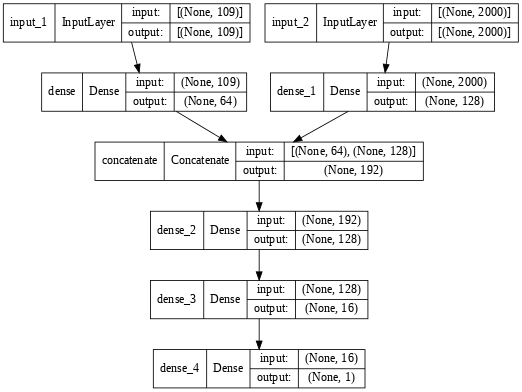

In [ ]:
model.summary()
plot_model(model, show_shapes=True, dpi=60)

In [ ]:
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], 
                    epochs=30,  validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]),
                    verbose=0, callbacks=[pltMae])

  Эпоха 0 модуль ошибки:  1.282
  Эпоха 1 модуль ошибки:  1.3026
  Эпоха 2 модуль ошибки:  1.2698
  Эпоха 3 модуль ошибки:  1.316
  Эпоха 4 модуль ошибки:  1.2878
  Эпоха 5 модуль ошибки:  1.3548
  Эпоха 6 модуль ошибки:  1.2629
  Эпоха 7 модуль ошибки:  1.4884
  Эпоха 8 модуль ошибки:  1.4553
  Эпоха 9 модуль ошибки:  1.6427
  Эпоха 10 модуль ошибки:  1.2566
  Эпоха 11 модуль ошибки:  1.2409
  Эпоха 12 модуль ошибки:  1.2322
  Эпоха 13 модуль ошибки:  1.3179
  Эпоха 14 модуль ошибки:  1.2234
  Эпоха 15 модуль ошибки:  1.9932
  Эпоха 16 модуль ошибки:  1.3401
  Эпоха 17 модуль ошибки:  2.4351
  Эпоха 18 модуль ошибки:  1.2469
  Эпоха 19 модуль ошибки:  1.2512
  Эпоха 20 модуль ошибки:  1.8794
  Эпоха 21 модуль ошибки:  1.2434
  Эпоха 22 модуль ошибки:  1.2944
  Эпоха 23 модуль ошибки:  1.2238
  Эпоха 24 модуль ошибки:  1.2564
  Эпоха 25 модуль ошибки:  1.212
  Эпоха 26 модуль ошибки:  1.7691
  Эпоха 27 модуль ошибки:  1.8219
  Эпоха 28 модуль ошибки:  1.2911
  Эпоха 29 модуль ошибки:  

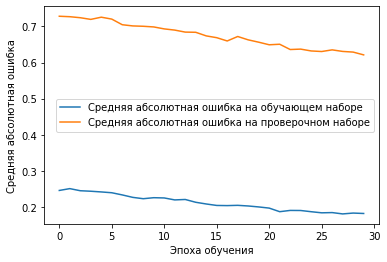

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer=Adadelta(learning_rate=0.05), loss='mse') # Вот нравится мне Adadelta. Главное уловить шаг, работает без dropout

In [ ]:
history1 = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=30, batch_size=128,# почему в ноутбуке не указан batch_size не знаю, но я поставил, быстрее
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

  Эпоха 0 модуль ошибки:  1.385
  Эпоха 1 модуль ошибки:  1.4636
  Эпоха 2 модуль ошибки:  1.2093
  Эпоха 3 модуль ошибки:  1.351
  Эпоха 4 модуль ошибки:  1.225
  Эпоха 5 модуль ошибки:  1.4219
  Эпоха 6 модуль ошибки:  1.3701
  Эпоха 7 модуль ошибки:  1.6209
  Эпоха 8 модуль ошибки:  2.1669
  Эпоха 9 модуль ошибки:  1.3887
  Эпоха 10 модуль ошибки:  1.9997
  Эпоха 11 модуль ошибки:  1.2729
  Эпоха 12 модуль ошибки:  1.3669
  Эпоха 13 модуль ошибки:  1.3227
  Эпоха 14 модуль ошибки:  1.5459
  Эпоха 15 модуль ошибки:  1.277
  Эпоха 16 модуль ошибки:  6.672
  Эпоха 17 модуль ошибки:  1.6339
  Эпоха 18 модуль ошибки:  1.3533
  Эпоха 19 модуль ошибки:  2.2286
  Эпоха 20 модуль ошибки:  1.6362
  Эпоха 21 модуль ошибки:  1.686
  Эпоха 22 модуль ошибки:  1.2406
  Эпоха 23 модуль ошибки:  1.209
  Эпоха 24 модуль ошибки:  1.2203
  Эпоха 25 модуль ошибки:  1.4569
  Эпоха 26 модуль ошибки:  1.2151
  Эпоха 27 модуль ошибки:  1.2118
  Эпоха 28 модуль ошибки:  1.3251
  Эпоха 29 модуль ошибки:  1.49

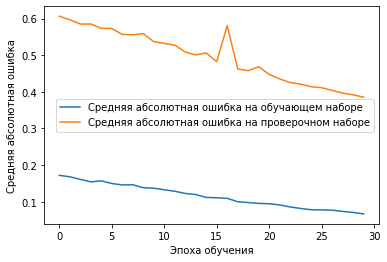

In [ ]:
plt.plot(history1.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history1.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

**ВЫВОД:** Есть куда стремится✌. Изменил, по сравнению Ультра лайт, нейроны на входе, немного поменял оптимизатор один на elu. Стало хуже примерно на 30%. На Ультра лайт на входе были х1=30, х2=300. после объединения х был со слоями 150 и 16. а выход после 10 эпохи 1,0516. Есть над чем подумать. Но главное, модель работает, и с ней можно экспериментировать.